In [5]:
import os
import scanpy as sc
import numpy as np
import torch

from scBTF import SingleCellTensor, SingleCellBTF, FactorizationSet

In [6]:
adata = sc.read("data/combined_dataset_final_v2.h5ad")

#### Pseudobulk and Tensorize single nucleus data

In [9]:
sample_label = "donor"
celltype_label = "cell_types_level_3"

sc_tensor = SingleCellTensor.from_anndata(adata,
    sample_label=sample_label,
    celltype_label=celltype_label,
    enrich_db_genes_only=True,
    normalize=True
)
sc_tensor.tensor = sc_tensor.tensor.round()

Building tensor from matrix: 100%|██████████| 15/15 [00:01<00:00, 12.65it/s]


#### Run scBTF and save factor sets

In [58]:
if not os.path.exists(f"results/sn_factorization.pkl"):
    factorization_set = SingleCellBTF.factorize(
        sc_tensor = sc_tensor,
        rank = [20],
        model = 'gamma_poisson',
        n_restarts = 20,
        num_steps = 1500,
        init_alpha = 1e2,
        plot_var_explained = False
    )
    factorization_set.save(f"results/sn_factorization.pkl")
else:
    factorization_set = FactorizationSet.load("results/sn_factorization.pkl")
factorization_set

Single cell factorization object with the following params:
        Tensor size 15 x 15 x 13941
        Ranks: [12, 16, 20, 24, 28]

#### Assess factorization quality and select rank

In [ ]:
fig = factorization_set.rank_metrics_plot()

In [ ]:
factorization_set.plot_gene_factor_cluster_metrics_per_rank(rank=20)

In [ ]:
factorization_set.gene_consensus_matrix_plots()

#### Generate consensus factorization using median of restart factors

In [55]:
if not os.path.exists(f"results/sn_bayesian_consensus_factorization.pkl"):
    reconstructed_all = FactorizationSet()
    reconstructed_all.sc_tensor = factorization_set.sc_tensor

    for selected_rank in factorization_set.get_ranks():
        # Use median of clustered gene factors to reconstruct a final factorization
        medians = factorization_set.reconstruct_factors_from_median_gene_factor(rank = selected_rank)
        reconstructed = SingleCellBTF.factorize(
            sc_tensor = factorization_set.sc_tensor,
            rank = selected_rank,
            n_restarts = 1,
            init_alpha = 1e2,
            num_steps = 1500,
            model = 'gamma_poisson_fixed',
            fixed_mode = 2,
            fixed_value = torch.from_numpy(medians.T).float(),
            plot_var_explained = False
        )

        gene_factor = reconstructed.get_factorization(rank = selected_rank, restart_index = 0).gene_factor['mean'].numpy()
        print((1 - np.isclose(medians.T, gene_factor, atol=2)).sum(), '/', medians.flatten().shape[0], ' mismatches in final gene factors')
        print(f'variance explained by reconstructed factorization = {reconstructed.variance_explained(rank=selected_rank, restart_index=0).item() :.3}')
        reconstructed_all.factorizations[selected_rank] = reconstructed.factorizations[selected_rank]
    reconstructed_all.save(f"results/sn_bayesian_consensus_factorization.pkl")
else:
    reconstructed_all = FactorizationSet.load("results/sn_bayesian_consensus_factorization.pkl")
reconstructed_all

Single cell factorization object with the following params:
        Tensor size 15 x 15 x 13527
        Ranks: [12, 16, 20, 24, 28]

In [ ]:
reconstructed_all.sc_tensor.sample_features.loc['H09_370','ebv_status'] = 'positive'
reconstructed_all.sc_tensor.sample_features['sample_type'] = \
    reconstructed_all.sc_tensor.sample_features['condition'].astype(str) + \
    reconstructed_all.sc_tensor.sample_features['ebv_status'].astype(str).apply(lambda x:''if x=='na' else '_'+x)
reconstructed_all.sc_tensor.sample_features['sample_type'] = \
    reconstructed_all.sc_tensor.sample_features['sample_type'].map({'HL_negative': 'HL EBV-', 'HL_positive': 'HL EBV+', 'RLN': 'RLN'})

#### Visualize factors

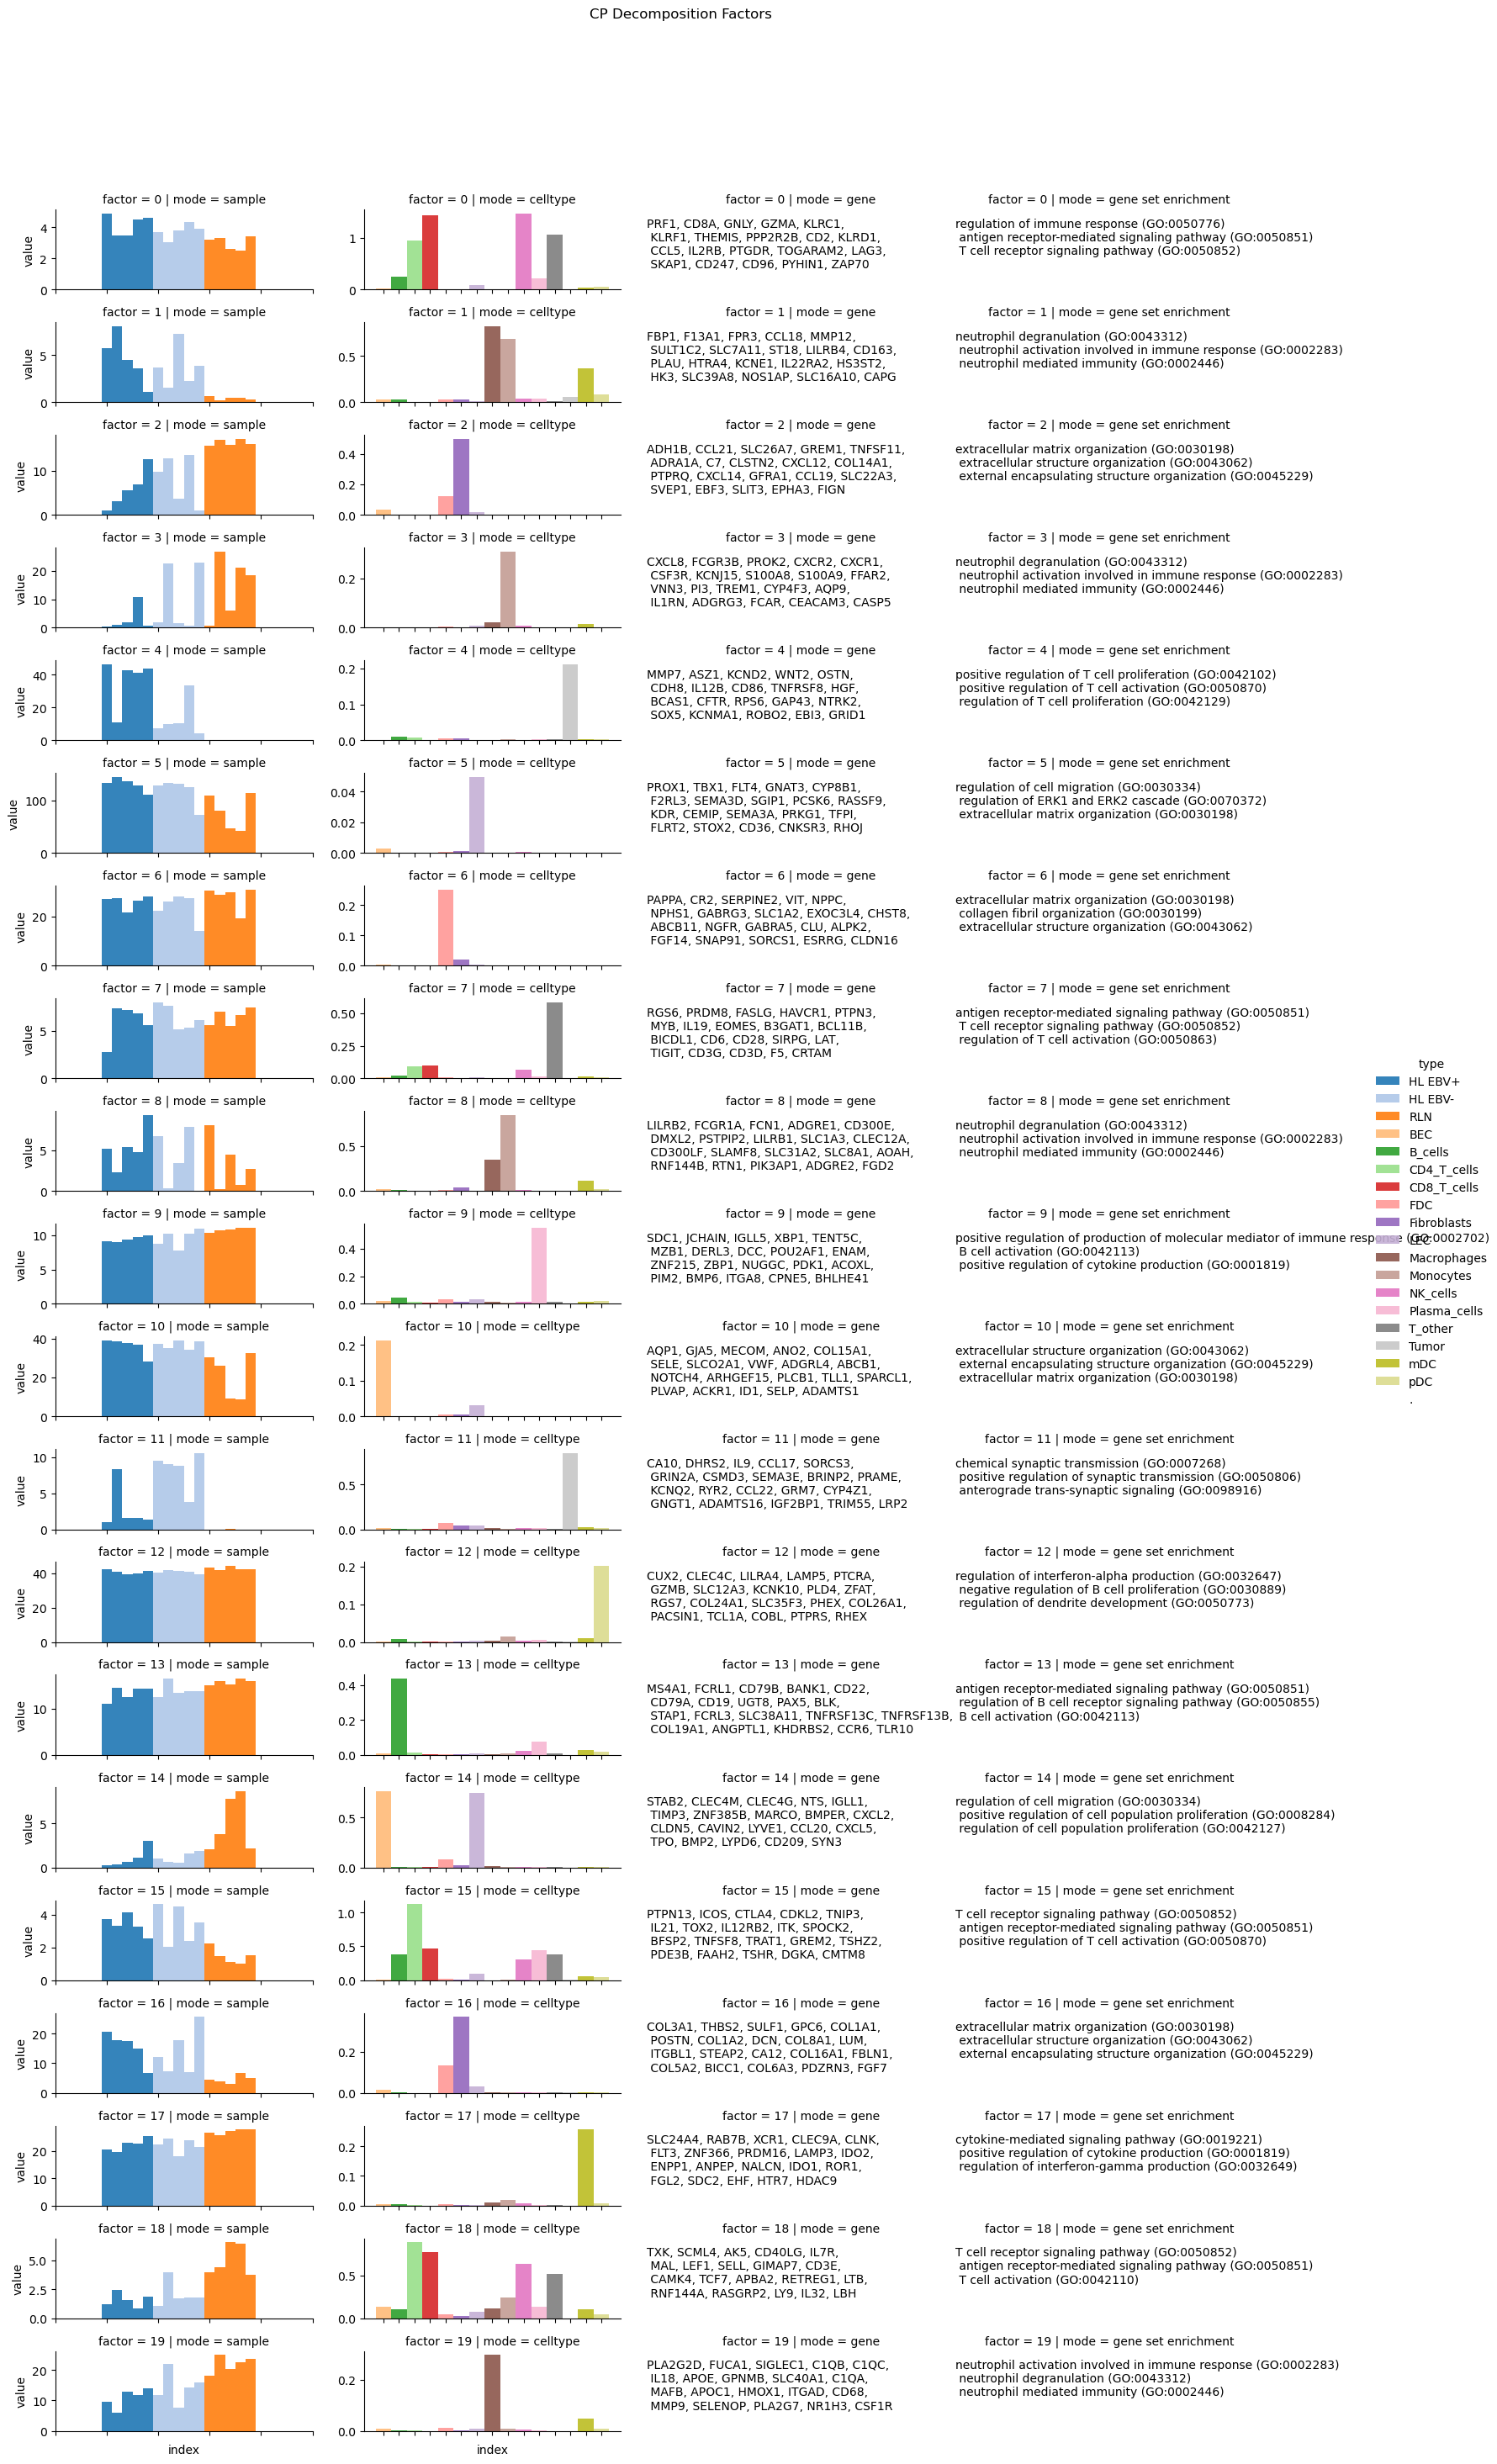

In [52]:
fig = reconstructed_all.plot_components(rank=20, restart_index=0, entropy = 2, eps = 0.5,
                                    threshold = 0.3, sort_by = 'other', plot_erichment_terms=True,
                                    normalize_gene_factors=True)
fig